## To do list - 
1. Incorporate the measurement part
2. Time dynamics
3. Propagator

## Testing the Controlled CZS gate

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import*
sqrt = np.sqrt
pi   = np.pi

In [3]:
A = destroy(3)
Alpha = -2*pi*210e6

In [4]:
Nlevels = 3
Nqubits = 3
def CZS(control, target1, target2):
    
    '''
    This function returns the two operators for three qubit gate Controlled CZs 
    on which the drives lambda_1 and lambda_2 can be applied with an exponential 
    factor to account for the nonlinearity of the third energy level. 
    Refer PRX QUANTUM 2, 040348 (2021).
    
    Arguments-
    control        :      control qubit (q0 in the main article)
    target1        :      first target qubit (q1 in the main article)
    target2        :      second target qubit (q2 in the main article)
    
    Returns-
    oper_lambda1   :      |110><200| equivalent of the main article 
                          in the total Hilbert space.
                          
    oper_lambda2   :      |101><200| equivalent of the main article
                          in the total Hilbert space.
    
    
    '''

    l0 = basis(Nlevels, 0)
    l1 = basis(Nlevels, 1)
    l2 = basis(Nlevels, 2)

    oper_lambda1 = []
    oper_lambda2 = []
    for i in range(Nqubits):

        if i == control:    
            o1 = l1*l2.dag()
            o2 = l1*l2.dag()
            oper_lambda1.append(o1)
            oper_lambda2.append(o2)



        elif i == target1:
            o1 = l1*l0.dag()
            o2 = l0*l0.dag() + l1*l1.dag()
            oper_lambda1.append(o1)
            oper_lambda2.append(o2)


        elif i == target2:
            o1 = l0*l0.dag() + l1*l1.dag()
            o2 = l1*l0.dag()
            oper_lambda1.append(o1)
            oper_lambda2.append(o2)


        else:
            oper_lambda1.append((qeye(Nlevels)))
            oper_lambda2.append((qeye(Nlevels)))


    oper_lambda1 = tensor(oper_lambda1)
    oper_lambda2 = tensor(oper_lambda2)
    
    return oper_lambda1, oper_lambda2



In [16]:
gate_time_CZS = 250*1e-9
Om_CZS =(pi/(sqrt(2)*gate_time_CZS))


S0 = basis(3,0)
S1 = basis(3,1)
S2 = basis(3,2)

S100 = tensor(S1, S0, S0)

S110 = tensor(S1, S1, S0)
S200 = tensor(S2, S0, S0)
S101 = tensor(S1, S0, S1)

S201 = tensor(S2, S0, S1)
S111 = tensor(S1, S1, S1)
S210 = tensor(S2, S1, S0)


X, Y= CZS(0,1,2)

In [17]:
a1 = tensor(destroy(3), qeye(3), qeye(3))
a2 = tensor(qeye(3), destroy(3), qeye(3))
a3 = tensor(qeye(3), qeye(3), destroy(3))

Ham = 0.5*Alpha*(a1.dag()*a1.dag()*a1*a1 + \
            a2.dag()*a2.dag()*a2*a2 + \
            a3.dag()*a3.dag()*a3*a3)

def al(t, args):
    return np.exp(1j*Alpha*t)

def ald(t, args):
    return np.exp(-1j*Alpha*t)

(0.0, 1.0)

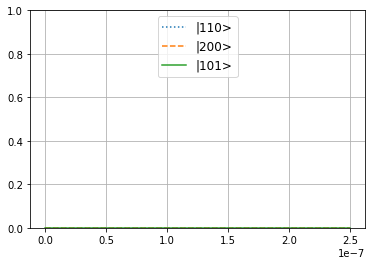

In [25]:
ang = 0
Phi = -np.exp(1j*ang)


tlist = np.linspace(0,gate_time_CZS, 101)
psi0 = (tensor(0*S1, S1, S0) + 0.25*tensor(S1,S1,S1) +  0*tensor(S1, S0, S1)).unit() 
e_ops = [S110*S110.dag(), S111*S111.dag(), S101*S101.dag(), S201*S201.dag(), S210*S210.dag(), \
         S200*S200.dag(), S100*S100.dag()]
res = mesolve([Ham , \
               [Om_CZS*(X), al], [Om_CZS*(X.dag()), ald] , \
               [Phi*Om_CZS*(Y), al], [np.conjugate(Phi)*Om_CZS*(Y.dag()), ald]], \
               psi0, tlist, c_ops = [], e_ops = e_ops\
             ,options = Options(store_final_state = True))
plt.plot(tlist, res.expect[0], ':', label = '|110>')
plt.plot(tlist, res.expect[5], '--',label = '|200>')
plt.plot(tlist, res.expect[2], label = '|101>')


plt.grid('on')
plt.legend(loc = 'upper center', fontsize = 12)
plt.ylim([0,1])

In [31]:
import itertools as it
def to2levels(dm):
    '''
    This function returns the density matrix in the computational subspace.
    
    Arguments-
    dm          :      Density matrix in the total Hilbert space
    
    Returns-
    Prob_array  :      Array of probabilities in the computational space
    
    '''


    levels= list(map(",".join, it.product(*[map(str, range(Nlevels))])))
    states = ["".join(seq) for seq in it.product(levels, repeat=Nqubits)]
    Prob_array = []
    counter = 0
    for i in states:
        if '2' not in i:
            Prob_array.append(dm[counter, counter])
        counter = counter + 1
    
    Prob_array = np.array(Prob_array)
    norm = 1/np.sum(Prob_array)
    return Prob_array

Qobj(to2levels(res.final_state*res.final_state.dag()))

Quantum object: dims = [[8], [1]], shape = (8, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]]

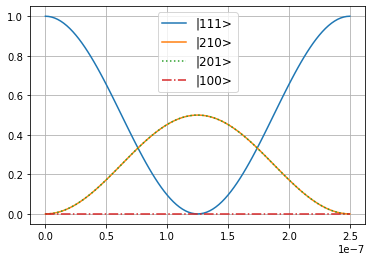

In [20]:
plt.plot(tlist, res.expect[1], label = '|111>')
plt.plot(tlist, res.expect[4], label = '|210>')
plt.plot(tlist, res.expect[3],':' ,label = '|201>')
plt.plot(tlist, res.expect[6],'-.' ,label = '|100>')
plt.legend(loc = 'upper center', fontsize = 12)
plt.grid('on')

In [21]:
print("Population of |101>")
print("-"*20)
print("Before \t", np.round(np.real(psi0.full()[10]),2)[0], "\t\t", np.round(np.imag(psi0.full()[10]),2)[0])
print("After \t", np.round(np.real(res.final_state.full()[10]),2)[0], "\t", np.round(np.imag(res.final_state.full()[10]),2)[0])

Population of |101>
--------------------
Before 	 0.0 		 0.0
After 	 0.0 	 0.0


In [49]:
print("Population of |110>")
print("-"*20)
print("Before \t", np.round(np.real(psi0.full()[12]),2)[0], "\t\t", np.round(np.imag(psi0.full()[12]),2)[0])
print("After \t", np.round(np.real(res.final_state.full()[12]),2)[0], "\t", np.round(np.imag(res.final_state.full()[12]),2)[0])

Population of |110>
--------------------
Before 	 0.93 		 0.0
After 	 0.0 	 -0.28


In [50]:
print("Population of |111>")
print("-"*20)
print("Before \t", np.round(np.real(psi0.full()[13]),2)[0],"\t\t", np.round(np.imag(psi0.full()[13]),2)[0])
print("After \t",  np.round(np.real(res.final_state.full()[13]),2)[0],"\t", np.round(np.imag(res.final_state.full()[13]),2)[0])

Population of |111>
--------------------
Before 	 0.23 		 0.0
After 	 -0.23 	 -0.0


# 4 qubits

In [4]:
import numpy as np
from qutip import*
sqrt = np.sqrt
pi   = np.pi
Alpha = -2*pi*200e6
gate_time_CZS = 250*1e-9
Om_CZS = pi/(sqrt(2)*gate_time_CZS)

def al(t, args):
    return np.exp(1j*Alpha*t)

def ald(t, args):
    return np.exp(-1j*Alpha*t)


Nqubits = 4
Nlevels = 3


S0 = basis(3,0)
S1 = basis(3,1)
S2 = basis(3,2)


X, Y= CZS(1,0,3)
# Control = 1
# Target1 = 0
# Target2 = 3

S1110 = tensor(S1, S1, S1, S0)
S0210 = tensor(S0, S2, S1, S0)
S0111 = tensor(S0, S1, S1, S1)

S0211 = tensor(S0, S2, S1, S1)
S1111 = tensor(S1, S1, S1, S1)
S1210 = tensor(S1, S2, S1, S0)

S = tensor(S2, S2, S2, S2)

a1 = tensor(destroy(3), qeye(3), qeye(3), qeye(3))
a2 = tensor(qeye(3), destroy(3), qeye(3), qeye(3))
a3 = tensor(qeye(3), qeye(3), destroy(3), qeye(3))
a4 = tensor(qeye(3), qeye(3), qeye(3), destroy(3))

Ham = 0.5*Alpha*(a1.dag()*a1.dag()*a1*a1 + \
            a2.dag()*a2.dag()*a2*a2 + \
            a3.dag()*a3.dag()*a3*a3 + a4.dag()*a4.dag()*a4*a4)




tlist = np.linspace(0,gate_time_CZS, 101)
psi0 = (0.7*tensor(S1, S1, S1, S0) + 0.5*tensor(S0, S1, S1, S1) + tensor(S1, S1, S1, S1)).unit()
e_ops = [S1110*S1110.dag(), S0210*S0210.dag(), S0111*S0111.dag(), S0211*S0211.dag(), S1111*S1111.dag(), \
         S1210*S1210.dag(), S*S.dag()]



In [6]:
tlist = np.linspace(0,gate_time_CZS, 101)

res = mesolve([Ham , \
               [Om_CZS*(X), al], [Om_CZS*(X.dag()), ald] , \
               [Om_CZS*(Y), al], [Om_CZS*(Y.dag()), ald]], \
               psi0, tlist, c_ops = [], e_ops = e_ops\
             ,options = Options(store_final_state = True))

(0.0, 1.0)

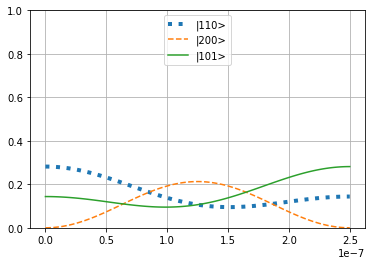

In [7]:
import matplotlib.pyplot as plt
plt.plot(tlist, res.expect[0], ':', label = '|110>', linewidth = 4)
plt.plot(tlist, res.expect[1], '--',label = '|200>')
plt.plot(tlist, res.expect[2], label = '|101>')


plt.grid('on')
plt.legend(loc = 'upper center', fontsize = 10)
plt.ylim([0,1])

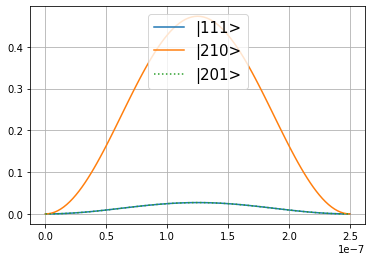

In [41]:
plt.plot(tlist, res.expect[4], label = '|111>')
plt.plot(tlist, res.expect[5], label = '|210>')
plt.plot(tlist, res.expect[3],':' ,label = '|201>')
plt.legend(loc = 'upper center', fontsize = 15)
plt.grid('on')

In [73]:
tensor(sigmaz(), sigmaz())

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0. -1.  0.]
 [ 0.  0.  0.  1.]]

In [5]:
import numpy as np
from qutip import*
sqrt = np.sqrt
pi   = np.pi
import Chalmers_Simulator_mesolve as CS

The quantum gates which are modelled in this code and their notations-
--------------------------------------------------------------------------------
Pauli X 		 PX
Pauli Y 		 PY
Pauli Z 		 PZ
Hadamard 		 HD


Controlled Z 		 CZ 		 Format:Tar_Con=[[control, target]]
Controlled CZS 		 CCZS 		 Format:Tar_Con=[[control, target1, target2, phi]]


## Noisefree and no ZZ coupling

In [51]:
class Add_gate:
    def __init__(gate, name, Tar_Con, angle):
        gate.name    = name
        gate.Tar_Con = Tar_Con
        gate.angle   = angle
        
Nqubits= 3
Nlevels= 3
Paulis_gt = 2.00e-8
gate_time_CCZS = 250*1e-9
CZ_gt = 2.71e-7
Diss  = [35.98e-6, 36.24e-6, 38.24e-6]
Deph  = [38.74e-6, 39.34e-6, 40.34e-6]
Alpha = -2*pi*200e6
ZZ_list = [[0,1],[1,2],[0,2]]
ZZ_strength = [0*2*pi*100e3,0*2*pi*100e3, 0*2*pi*100e3]
Hamiltonian, c_ops = CS.create_system_Hamiltonian(Nqubits, Nlevels, Paulis_gt, CZ_gt, gate_time_CCZS, Alpha, Diss, \
                                                  Deph, Texc = [], ZZ_list=[], ZZ_strength=[])

Ini = tensor(basis(3,1), basis(3,2), basis(3,1))

gate=[]
gate.append(Add_gate(name=["CCZS"], Tar_Con=[[0,1,2,pi/2]],      angle=[0]        ))
#gate.append(Add_gate(name=["CZ"],   Tar_Con=[[0,1]],             angle=[0]        ))

fstate_no_noise = CS.Execute(Hamiltonian, [], gate, Ini)

## Presence of noise and ZZ coupling 

In [52]:
ZZ_strength = [2*pi*150e3,2*pi*150e3, 2*pi*150e3]
Hamiltonian, c_ops = CS.create_system_Hamiltonian(Nqubits, Nlevels, Paulis_gt, CZ_gt, gate_time_CCZS, Alpha, Diss, \
                                                  Deph, Texc = [], ZZ_list=[], ZZ_strength=[])

fstate_noise = CS.Execute(Hamiltonian, c_ops, gate, Ini)

In [55]:
fidelity(fstate_no_noise*fstate_no_noise.dag(), fstate_noise)

0.9864511872290282

## Incorporating measurement Errors

In [71]:
def Measurement(Hamiltonian, c_ops, Ini, gate, CM, coeff):
    '''
    This function returns the diagonal elements (population) of the density 
    matrix for a given measurement gates and confusion matrix.
    
    Arguments-
    Hamiltonian  :  Bare Hamiltonian of the system
    c_ops        :  List of collapse operators
    Ini          :  Initial state before the measurement process begins
    gate         :  List of gate in the same procedure
    CM           :  Confusion matris in the computational subspace
    coeff        :  Coefficients in front of each measurement term in the cost function
    
    
    Returns-
    probabilities:  Diagonal elements of the density matrix subjected to the confusion
                    matrix in the computational subspace.
    '''
 
    
    probabilities = []
    
    for i in range(len(gate)):
        
        gate =  np.array(Info[i].name)
        TC   =  np.array(Info[i].Tar_Con)
        angle = np.array(Info[i].angle)
        npoints = 1000
        H1, tlist = pulse_hamiltonians(gate, TC, angle, npoints)
        
        H2 = sum(H1) + Hamiltonian
        final_dm = mesolve(H2, Ini, tlist, c_ops, e_ops = [], options = Options(store_final_state=True))
        
        state_in_comp_space = _3to2levels(final_dm)
        probabilities.append(coeff[i]*CM*state_in_comp_space)
        
    return probabilities
        
        
    
    
    
def _3to2levels(dm):
    '''
    This function returns the density matrix in the computational subspace.
    
    Arguments-
    dm          :      Density matrix in the total Hilbert space
    
    Returns-
    Prob_array  :      Array of probabilities in the computational space
    
    '''


    import itertools as it

    levels= list(map(",".join, it.product(*[map(str, range(Nlevels))])))
    states = ["".join(seq) for seq in it.product(levels, repeat=Nqubits)]
    Prob_array = []
    counter = 0
    for i in states:
        if '2' not in i:
            Prob_array.append(dm[counter, counter])
        counter = counter + 1
    
    return np.array(Prob_array)
        

[]